In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/shamecube/git/all-you-need-is-Bayes/src/models.py:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ll is 'Student':
/home/shamecube/git/all-you-need-is-Bayes/src/models.py:85: SyntaxWarning: "is" with a literal. Did you mean "=="?
  name="likelihood",


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples
from models import mmm_model
from utils import max_abs_scaler
from utils import create_trend_seasonality


In [3]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [4]:
raw = pd.read_csv('../data/data.csv')
df=raw.copy()


In [5]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)
df['day'] = df.start_of_week.dt.dayofyear


In [6]:
target_scaler, target_scaled = max_abs_scaler(target_data, True)
channel_scaler, channel_scaled = max_abs_scaler(channel_data,False)


<Axes: >

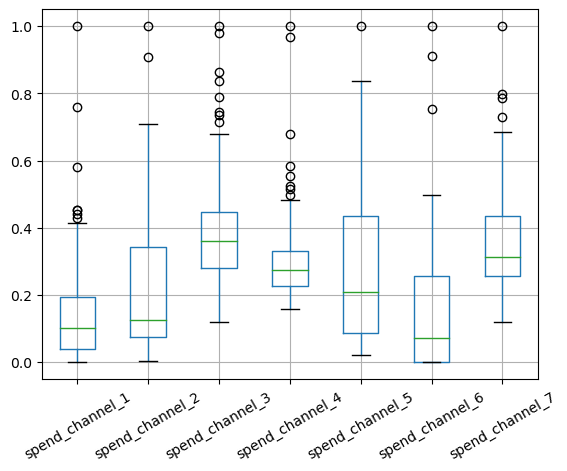

In [7]:
# outliers exist but the transformation is completed.
channel_scaled.boxplot( rot=30)

In [8]:
trend,seasonality = create_trend_seasonality(df)

In [9]:
model_input = {"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend": trend
} 
target = target_scaled

In [10]:
model,model_prior_predictive = mmm_model(model_input,target)

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


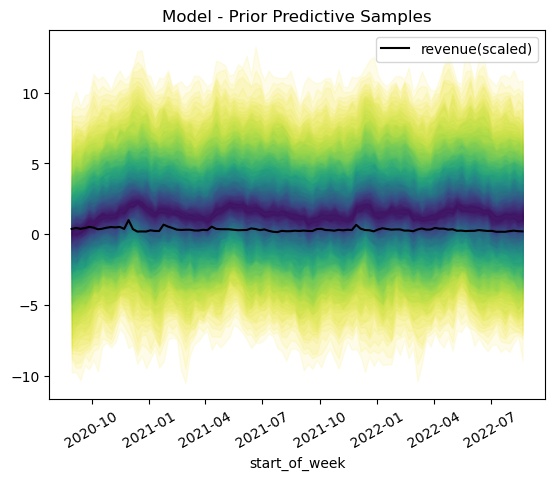

In [11]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [12]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:06.856282
Sampling...


Compiling.. :   0%|                                                    | 0/9000 [00:00<?, ?it/s]

  0%|                                                                  | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                    | 0/9000 [00:00<?, ?it/s]


  0%|                                                                  | 0/9000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                 | 0/9000 [00:06<?, ?it/s]


Running chain 3:   0%|                                                 | 0/9000 [00:06<?, ?it/s]

Running chain 1:   0%|                                                 | 0/9000 [00:06<?, ?it/s]

Running chain 0:   5%|█▉                                     | 450/9000 [00:13<02:08, 66.78it/s]


Running chain 3:   5%|█▉                                     | 450/9000 [00:13<02:15, 63.00it/s]

Running chain 0:  10%|███▊                                  | 900/9000 [00:15<01:15, 106.66it/s]


Running chain 3

Sampling time =  0:01:15.019436
Transforming variables...
Transformation time =  0:00:02.745087
Computing Log Likelihood...
Log Likelihood time =  0:00:03.020315


Sampling: [likelihood]


In [13]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','b_trend','beta_channel','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.478  0.193   0.132    0.827      0.001   
alpha[spend_channel_2]         0.599  0.187   0.259    0.928      0.001   
alpha[spend_channel_3]         0.449  0.170   0.138    0.765      0.001   
alpha[spend_channel_4]         0.512  0.191   0.152    0.845      0.001   
alpha[spend_channel_5]         0.498  0.188   0.151    0.832      0.001   
alpha[spend_channel_6]         0.554  0.173   0.227    0.853      0.001   
alpha[spend_channel_7]         0.501  0.182   0.165    0.834      0.001   
delay[spend_channel_1]         6.378  2.670   0.952   10.864      0.034   
delay[spend_channel_2]         3.703  2.332   0.001    8.585      0.030   
delay[spend_channel_3]         0.366  0.817   0.000    0.630      0.028   
delay[spend_channel_4]         4.875  3.242   0.000   10.205      0.030   
delay[spend_channel_5]         4.541  3.713   0.001   11.034      0.031   
delay[spend_channel_6]         1.342  0.766   0.070    2.207      0.009   
delay[spend_channel_7]         3.146  1.105   0.124    4.236      0.030   
intercept                      0.012  0.076  -0.127    0.160      0.001   
b_trend                       -0.187  0.080  -0.344   -0.041      0.001   
beta_channel[spend_channel_1]  0.114  0.086   0.000    0.269      0.001   
beta_channel[spend_channel_2]  0.225  0.104   0.037    0.422      0.001   
beta_channel[spend_channel_3]  0.374  0.122   0.142    0.606      0.002   
beta_channel[spend_channel_4]  0.088  0.075   0.000    0.223      0.001   
beta_channel[spend_channel_5]  0.041  0.045   0.000    0.125      0.000   
beta_channel[spend_channel_6]  0.302  0.096   0.119    0.484      0.002   
beta_channel[spend_channel_7]  0.323  0.113   0.107    0.537      0.001   
sigma                          0.057  0.007   0.044    0.071      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   28189.0   21823.0    1.0  
alpha[spend_channel_2]           0.001   24071.0   21347.0    1.0  
alpha[spend_channel_3]           0.001   18026.0   14882.0    1.0  
alpha[spend_channel_4]           0.001   38797.0   22498.0    1.0  
alpha[spend_channel_5]           0.001   33076.0   22026.0    1.0  
alpha[spend_channel_6]           0.001   22701.0   20836.0    1.0  
alpha[spend_channel_7]           0.001   20388.0   17691.0    1.0  
delay[spend_channel_1]           0.024    8331.0   12598.0    1.0  
delay[spend_channel_2]           0.021    6041.0   10399.0    1.0  
delay[spend_channel_3]           0.020    3488.0    1015.0    1.0  
delay[spend_channel_4]           0.021   11554.0   15848.0    1.0  
delay[spend_channel_5]           0.022   16072.0   20800.0    1.0  
delay[spend_channel_6]           0.009   11142.0    9152.0    1.0  
delay[spend_channel_7]           0.022    2221.0     992.0    1.0  
intercept                        0.001    2541.0    2978.0    1.0  
b_trend                          0.001    8409.0   10501.0    1.0  
beta_channel[spend_channel_1]    0.001    7864.0   13313.0    1.0  
beta_channel[spend_channel_2]    0.001    7497.0    8494.0    1.0  
beta_channel[spend_channel_3]    0.002    2573.0    1877.0    1.0  
beta_channel[spend_channel_4]    0.000   12722.0   14720.0    1.0  
beta_channel[spend_channel_5]    0.000   14231.0   15796.0    1.0  
beta_channel[spend_channel_6]    0.001    3158.0    2267.0    1.0  
beta_channel[spend_channel_7]    0.001    7943.0    6833.0    1.0  
sigma                            0.000   12924.0   21874.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


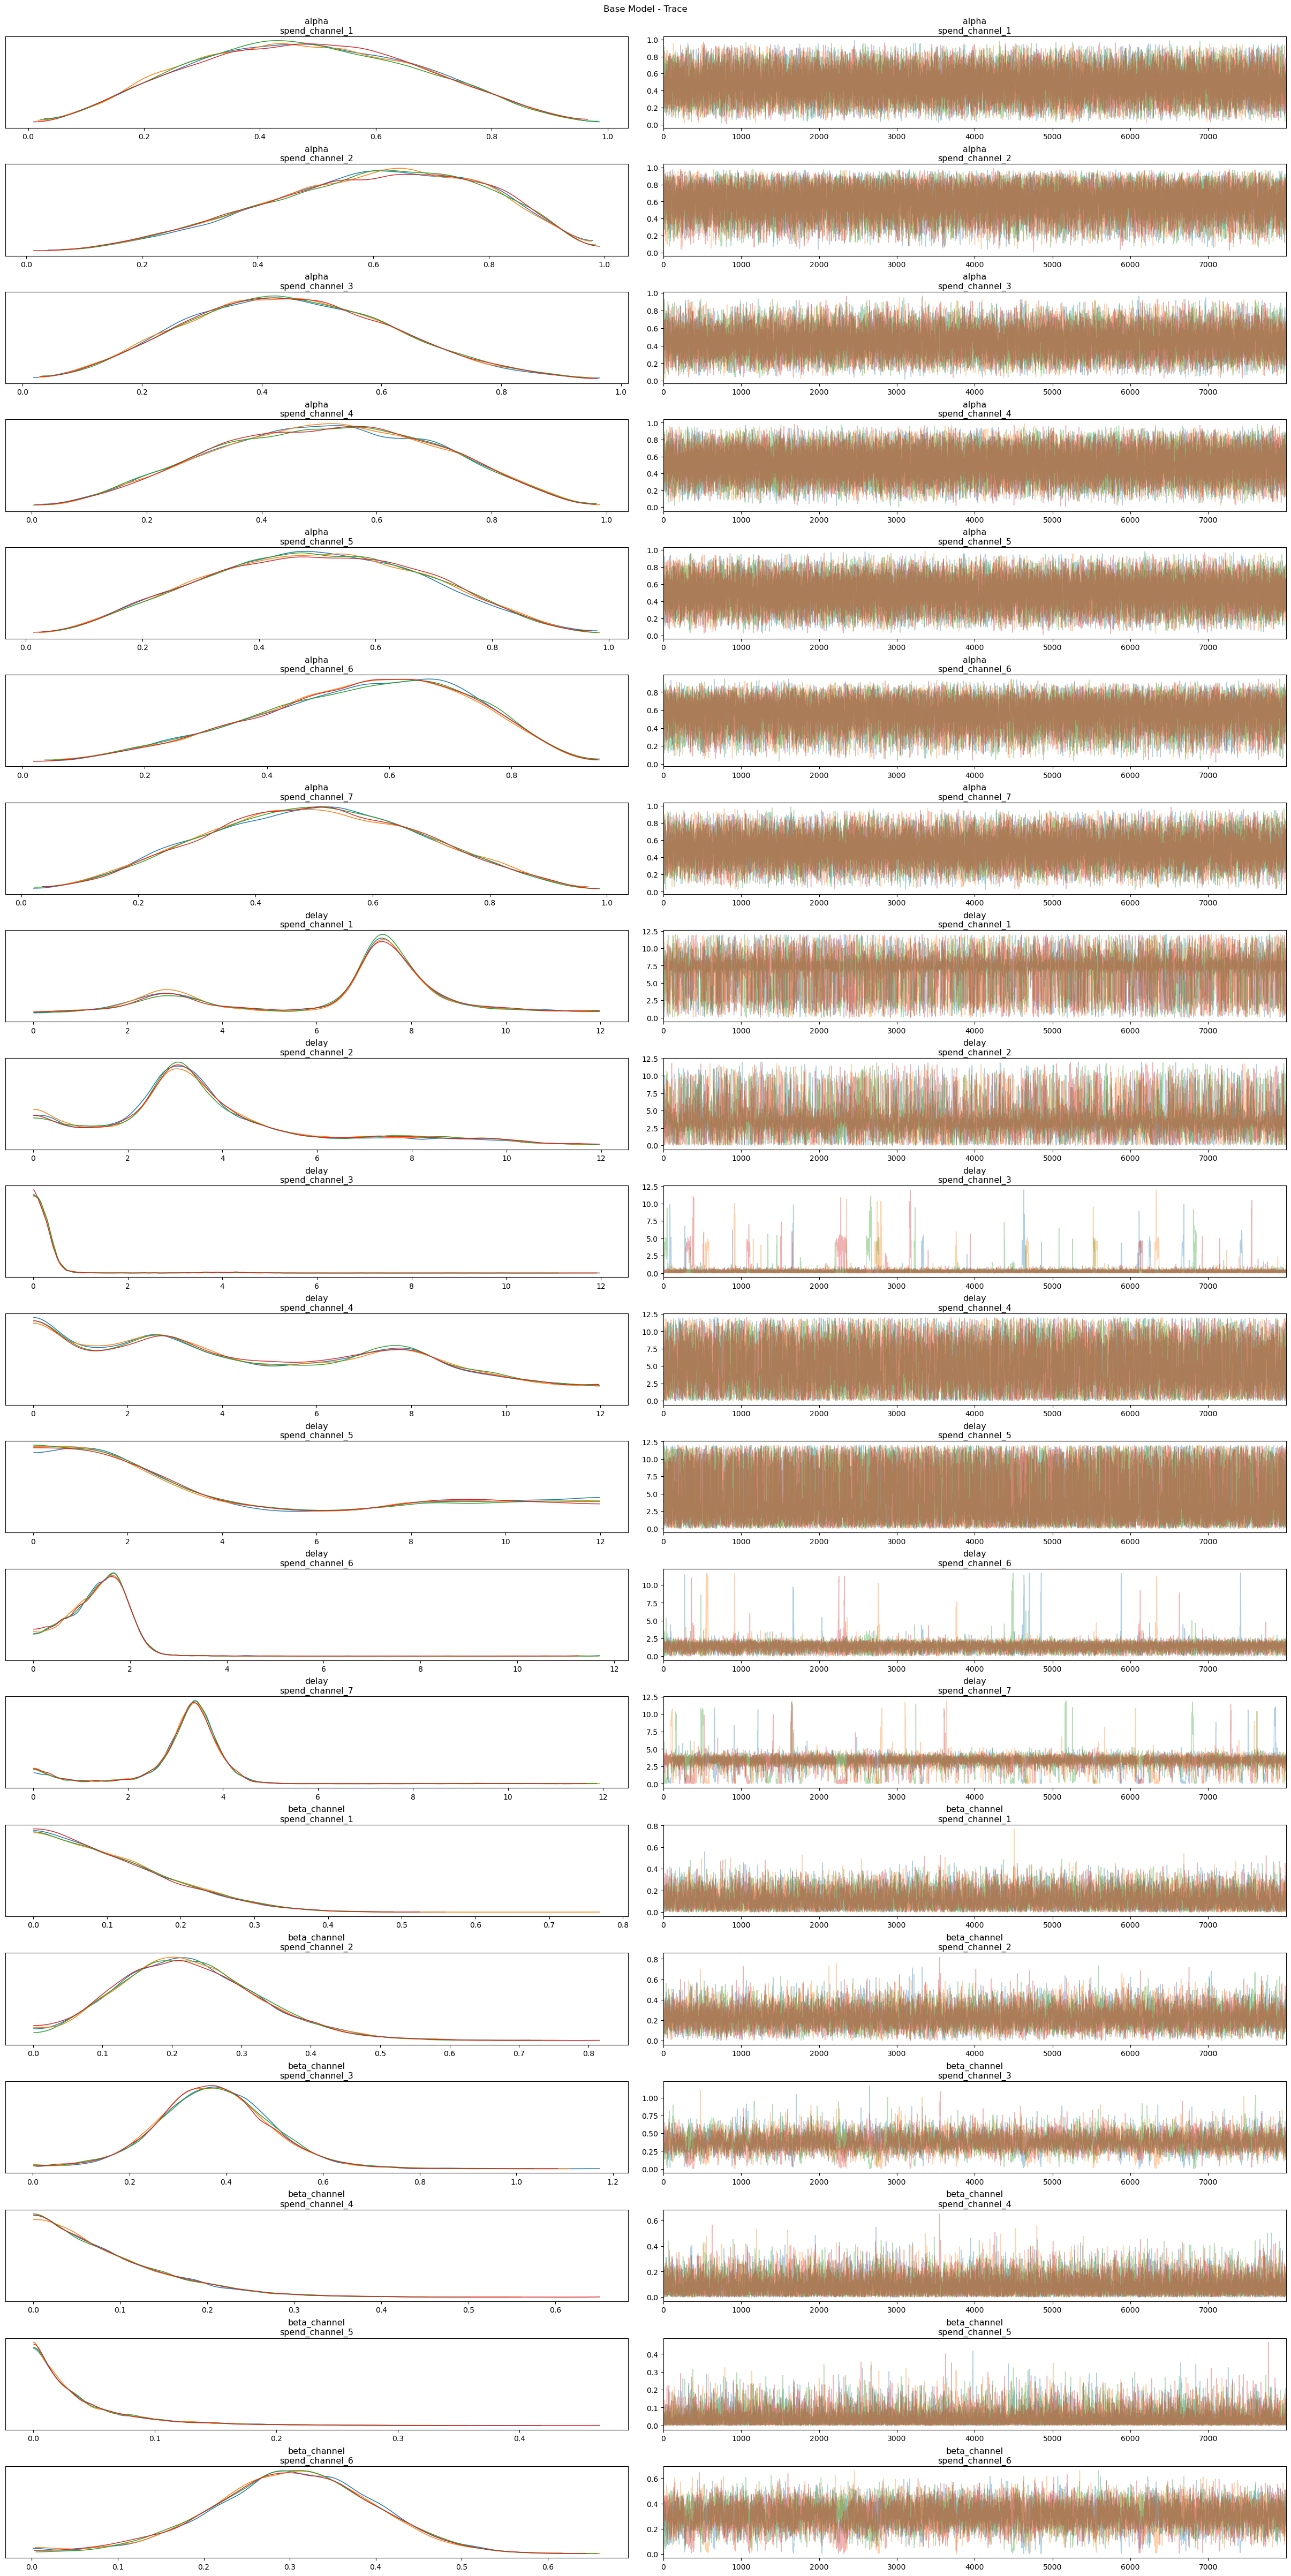

In [14]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','beta_channel','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()
# here we see on the right side distribtuion on each chain seperatly . on left we see the 
# convergence on each chain.

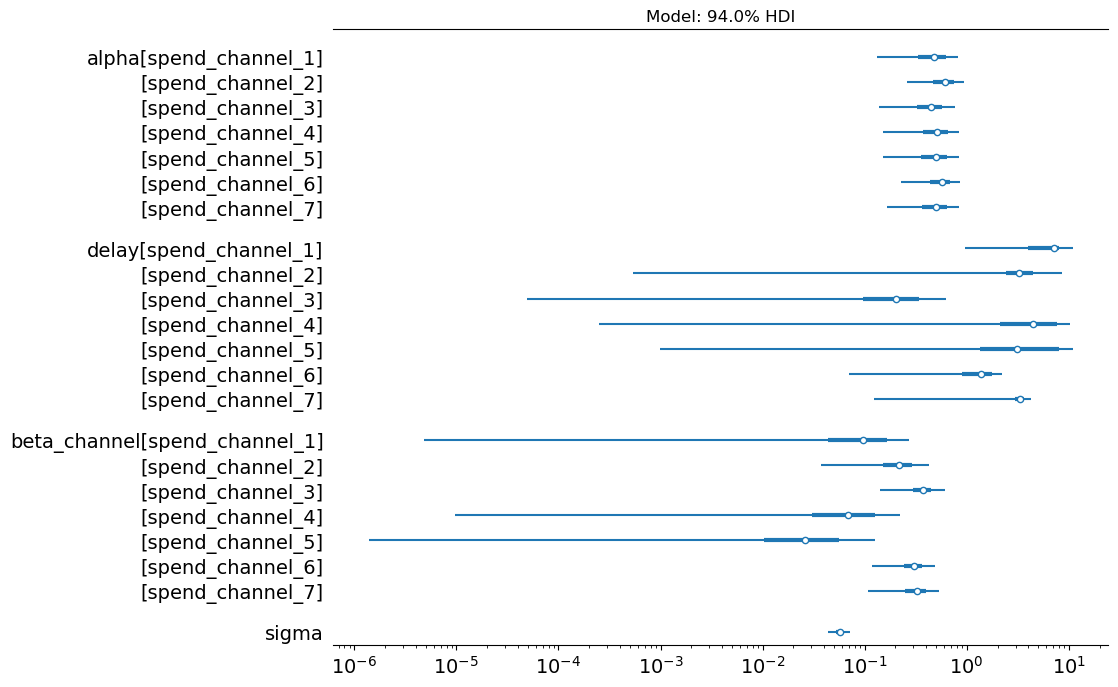

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

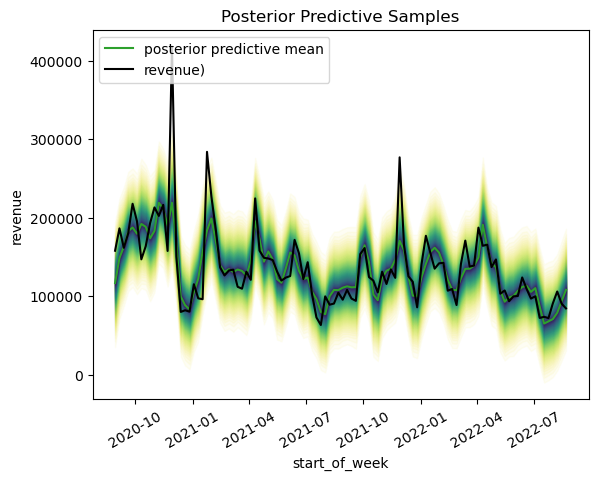

In [16]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


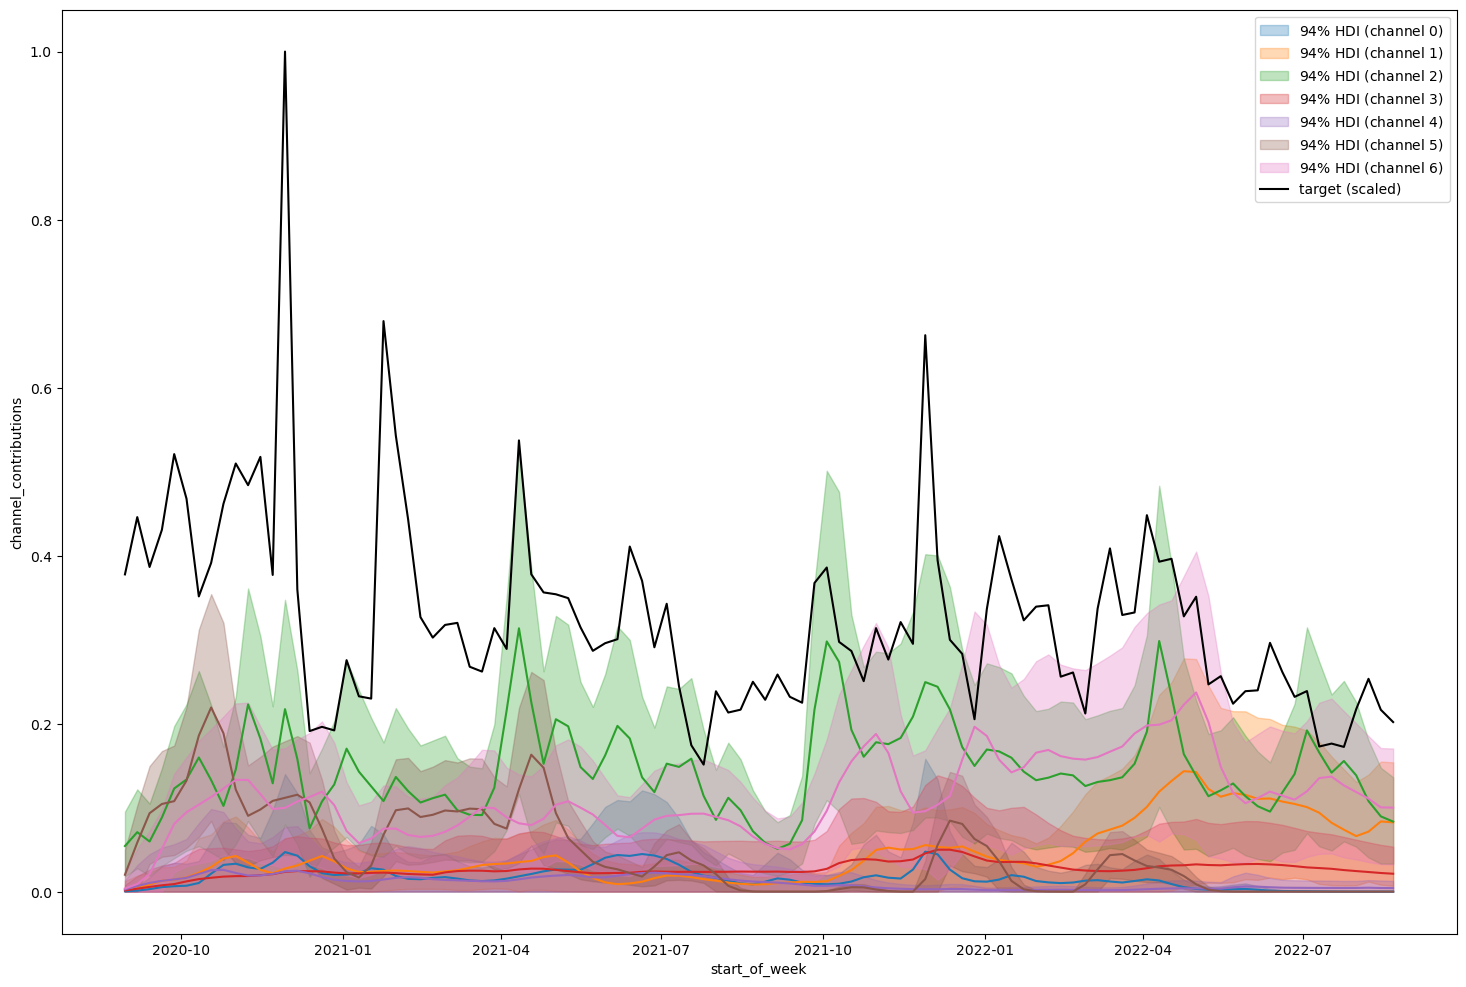

In [17]:
#The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots(figsize=(18, 12))

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI (channel {i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

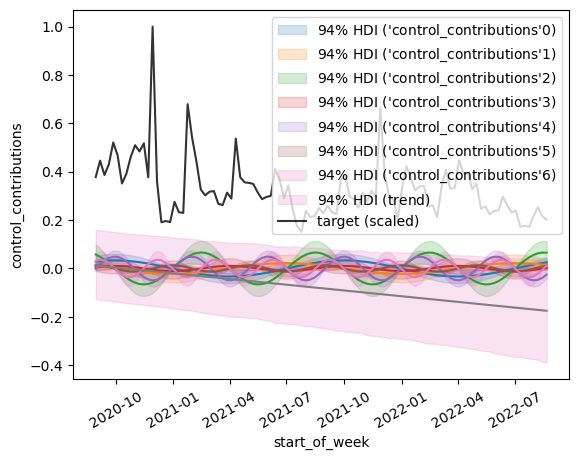

In [18]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ('control_contributions'{i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.xticks(rotation=30)
plt.show()

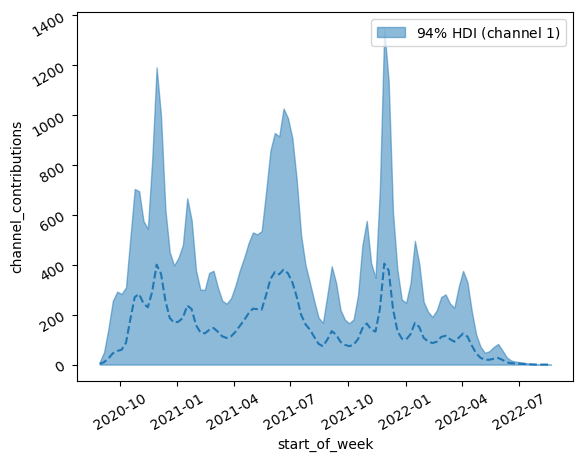

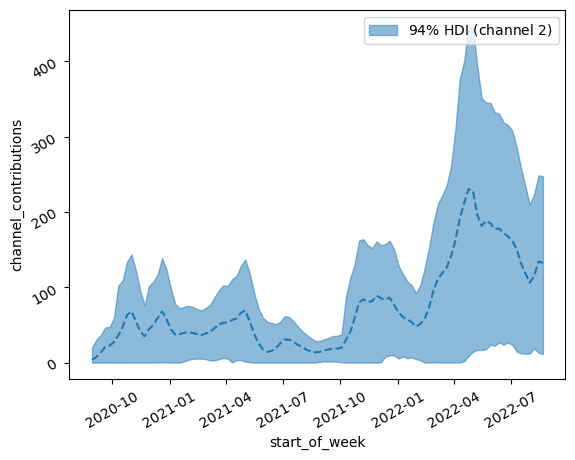

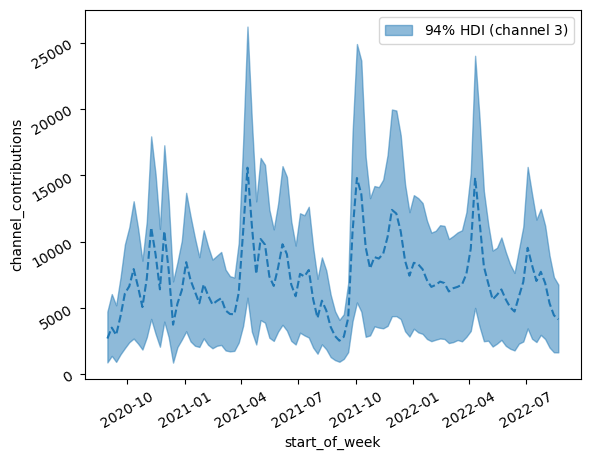

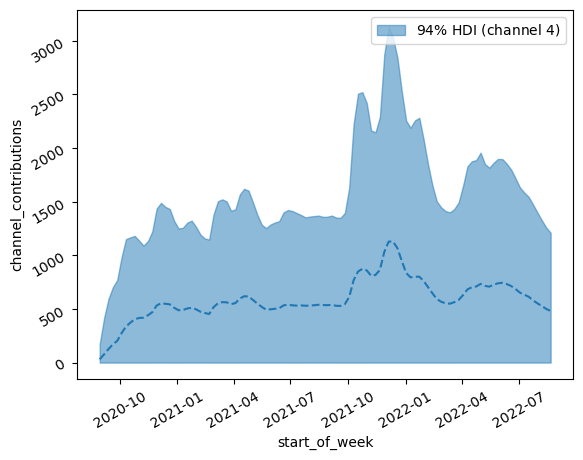

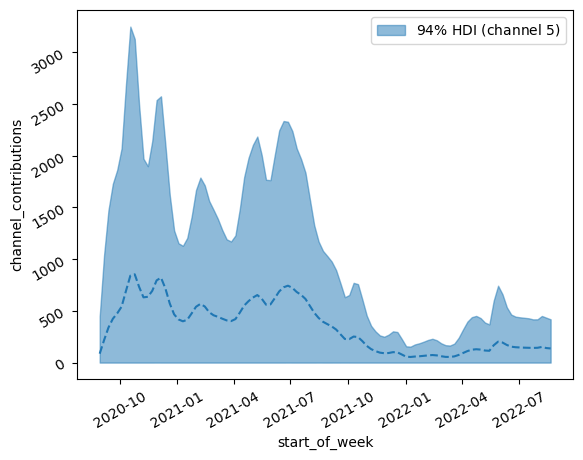

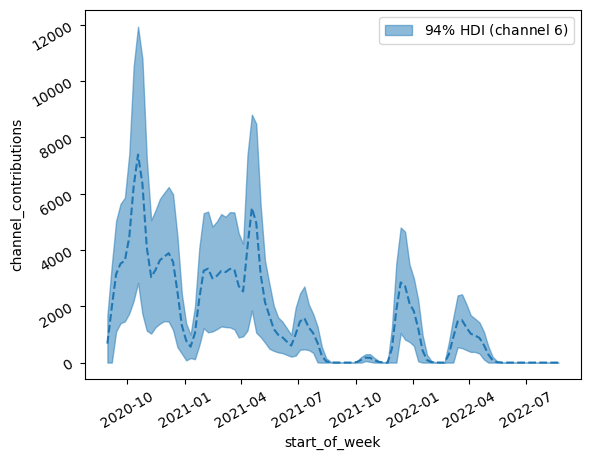

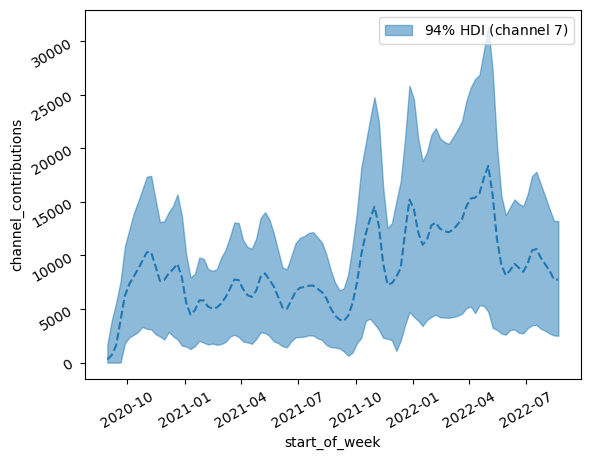

In [19]:
#channel contribtuion figures

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label=f"$94\%$ HDI (channel {i+1})",
    )
    ax.tick_params(labelrotation=30)
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
plt.show()

In [28]:
model_normal,model_prior_predictive_normal =  mmm_model(model_input,target,ll='Normal')

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, sigma]


In [29]:
model_normal

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 12)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ N(mu, sigma)

In [ ]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive_normal = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

In [ ]:
dataset_dict = {
    "model": model_trace,
    "model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")
df_comp

In [ ]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['beta_channel'],
    combined=True,
    figsize=(10, 7),
)
plt.show()